This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [1]:
%run 0_parameters.ipynb


This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
       
      
Using filename= ../data/2019-03-28
{'w': 28, 'minibatch_size': 100, 'train_batch_size': 50000, 'test_batch_size': 5000, 'noise_batch_size': 1000, 'mean': 0.1307, 'std': 0.3081, 'N_pic': 128, 'offset_std': 30, 'offset_max': 34, 'noise': 1.0, 'contrast': 1.0, 'sf_0': 0.2, 'B_sf': 0.3, 'N_theta': 6, 'N_azimuth': 26, 'N_eccentricity': 10, 'N_phase': 2, 'rho': 1.41, 'bias_deconv': True, 'p_dropout': 0.0, 'dim1': 500, 'dim2': 2000, 'lr': 0.001, 'do_adam': True, 'bn1_bn_momentum': 0.5, 'bn2_bn_momentum': 0.2, 'momentum': 0.1, 'epochs': 25, 'num_processes': 1, 'no_cuda': True, 'log_interval': 100, 'verbose': 1, 'filename': '../data/2019-03-28', 'seed': 2019, 'N_cv': 8, 'do_compute': True}
Overwriting train.py
2019-03-28T10:54:24+01:00

CPython 3.7.2
IPython 7.4.0

numpy 1.16.2
matplotlib 3.0.3
torch 1.0.1.post2

compiler   : Clang 10.0.0 (cl

In [2]:
figname = '../paper/fig_params'

In [3]:
%%writefile params.py
import os
import torch
from main import init, MetaML
from where import Where as ML
from what import WhatNet
        
import sys
opts = dict(filename='../data/2019-03-27', verbose=0, log_interval=0, do_compute=False  if len(sys.argv) > 1 else True)
#opts = dict(filename='debug', verbose=0, log_interval=0)

print(50*'-')
print(' parameter scan')
print(50*'-')

if True:
    args = init(**opts)
    #args.filename = '../data/2019-03-27'
    filename_train = args.filename + '_train.pt'
    if not(os.path.isfile(filename_train + '_lock')):
        open(filename_train + '_lock', 'w').close()
        print(50*'-')
        print('Default parameters')
        print(50*'-')
        from where import Where as ML
        from what import WhatNet
        ml = ML(args)
        ml.train(path=filename_train)
        # ml.main(path=args.filename)
        os.remove(filename_train + '_lock')

if True:
    args = init(**opts)
    mml = MetaML(args)
    if torch.cuda.is_available():
        mml.scan('no_cuda', [True, False])

    args = init(**opts)
    mml = MetaML(args)
    mml.scan('bias_deconv', [True, False])

results = {}
    
def update_results(results, parameter, accuracies):
    if not parameter in results.keys(): results[parameter] = dict(value=[], accuracy=[])
    for value in accuracies.keys():
        results[parameter]['value'].append(value)
        results[parameter]['accuracy'].append(accuracies[value][:-1].mean()*100)
    return results
            
for base in [2] if not args.filename == '../data/debug' else [2]:
    print(50*'-')
    print(' base=', base)
    print(50*'-')

    print(50*'-')
    print(' parameter scan : data')
    print(50*'-')
    args = init(**opts)
    mml = MetaML(args, base=base)
    for parameter in ['sf_0', 'B_sf', 'offset_std' , 'noise']: #, 'contrast'
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter, accuracies)
        
    print(50*'-')
    print(' parameter scan : network')
    print(50*'-')
    args = init(**opts)
    mml = MetaML(args)
    for parameter in ['dim1',
                      'bn1_bn_momentum',
                      'dim2',
                      'bn2_bn_momentum',
                      'p_dropout']:
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter, accuracies)

    print(' parameter scan : learning ')
    args = init(**opts)
    mml = MetaML(args, base=base)
    print(50*'-')
    print('Using SGD')
    print(50*'-')
    for parameter in ['lr', 'momentum', 'minibatch_size', 'epochs']:
        mml.parameter_scan(parameter)
    print(50*'-')
    print('Using ADAM')
    print(50*'-')
    args = init(**opts)
    args.do_adam = True
    mml = MetaML(args, tag='adam')
    for parameter in ['lr', 'momentum', 'minibatch_size', 'epochs']:
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter, accuracies)

    print(50*'-')
    print(' parameter scan : retina')
    print(50*'-')
    args = init(**opts)
    mml = MetaML(args)
    for parameter in ['N_theta',
                      'N_azimuth',
                      'N_eccentricity',
                      'rho']:
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter, accuracies)
        

Overwriting params.py


In [4]:
%run params.py scan

--------------------------------------------------
 parameter scan
--------------------------------------------------
--------------------------------------------------
Default parameters
--------------------------------------------------


/usr/local/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'where.WhereNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Loading file ../data/2019-03-19_train.pt
scanning over bias_deconv = [True, False]
For parameter bias_deconv = True ,  Accuracy=72.7% +/- 0.3%  in 13946.4 seconds
For parameter bias_deconv = False ,  Accuracy=73.2% +/- 0.0%  in 11114.9 seconds
--------------------------------------------------
 base= 2
--------------------------------------------------
--------------------------------------------------
 parameter scan : data
--------------------------------------------------
scanning over sf_0 = [0.1        0.11892071 0.14142136 0.16817928 0.2        0.23784142
 0.28284271 0.33635857 0.4       ]
For parameter sf_0 = 0.100 ,  Accuracy=66.6% +/- 0.3%  in 12092.7 seconds
For parameter sf_0 = 0.119 ,  Accuracy=67.3% +/- 0.1%  in 12423.9 seconds
For parameter sf_0 = 0.141 ,  Accuracy=68.7% +/- 0.0%  in 12041.9 seconds
For parameter sf_0 = 0.168 ,  Accuracy=71.2% +/- 0.4%  in 12207.2 seconds
For parameter sf_0 = 0.200 ,  Accuracy=72.6% +/- 0.0%  in 10596.1 seconds
For parameter sf_0 = 0.238 

In [5]:
print(accuracies)

{1.1856639455077373: array([6.56400000e-01, 6.58200000e-01, 6.58200000e-01, 6.58200000e-01,
       6.58200000e-01, 6.58200000e-01, 6.58200000e-01, 6.58200000e-01,
       1.74520218e+04]), 1.41: array([7.26200000e-01, 7.26200000e-01, 7.26200000e-01, 7.26200000e-01,
       7.26200000e-01, 7.26200000e-01, 7.26200000e-01, 7.26200000e-01,
       1.26797069e+04]), 1.6767820321538365: array([1.38000000e-01, 1.38400000e-01, 1.38400000e-01, 1.38400000e-01,
       1.38400000e-01, 1.38400000e-01, 1.38400000e-01, 1.38400000e-01,
       1.33523757e+04]), 1.994041122946064: array([1.24800000e-01, 1.30400000e-01, 1.30400000e-01, 1.30400000e-01,
       1.30400000e-01, 1.30400000e-01, 1.30400000e-01, 1.30400000e-01,
       1.35419781e+04]), 2.3713278910154747: array([1.26000000e-01, 1.30600000e-01, 1.30600000e-01, 1.30600000e-01,
       1.30600000e-01, 1.30600000e-01, 1.30600000e-01, 1.30600000e-01,
       1.35743797e+04]), 2.82: array([1.28600000e-01, 1.33200000e-01, 1.33200000e-01, 1.33200000e-01,
  

In [6]:
results['sf_0']['value'],  results['sf_0']['accuracy']

([0.1,
  0.11892071150027211,
  0.14142135623730953,
  0.16817928305074292,
  0.2,
  0.23784142300054423,
  0.28284271247461906,
  0.33635856610148585,
  0.4],
 [66.62750000000001,
  67.2825,
  68.67750000000001,
  71.18749999999999,
  72.61999999999999,
  74.1175,
  75.1625,
  76.08250000000001,
  76.5725])

## parameter scan

---> sf_0


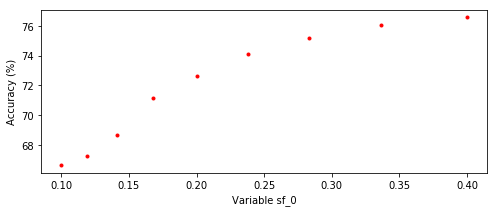

---> B_sf


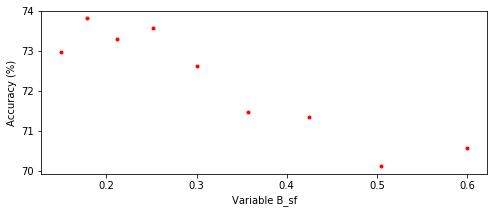

---> offset_std


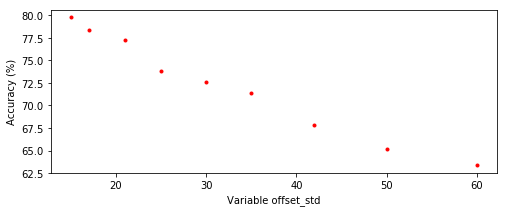

---> noise


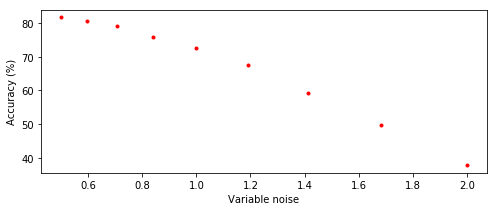

---> dim1


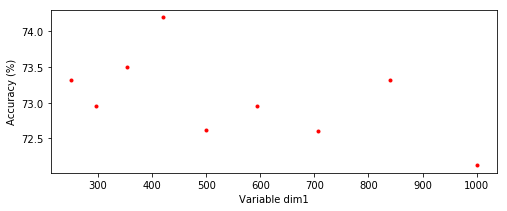

---> bn1_bn_momentum


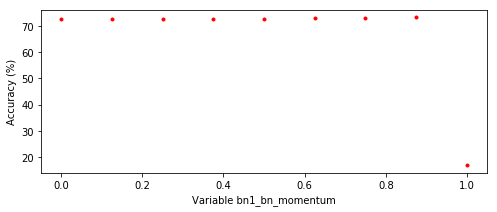

---> dim2


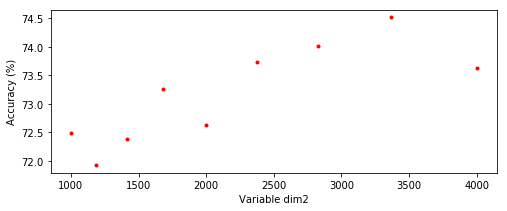

---> bn2_bn_momentum


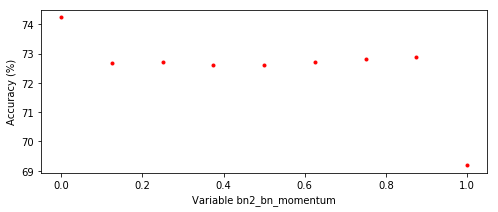

---> p_dropout


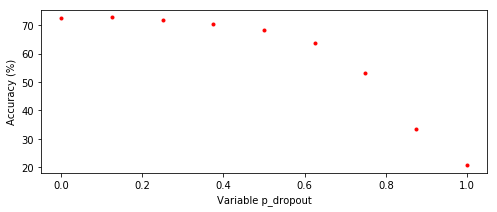

---> lr


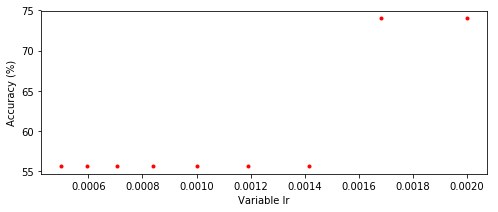

---> momentum


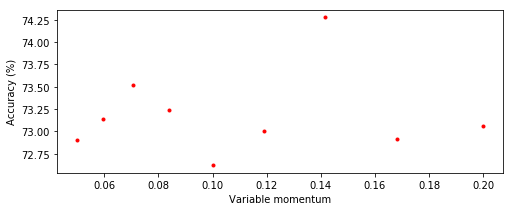

---> minibatch_size


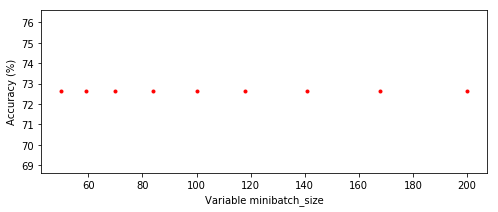

---> epochs


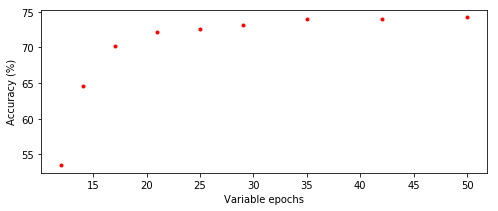

---> N_theta


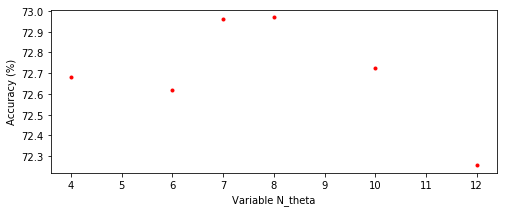

---> N_azimuth


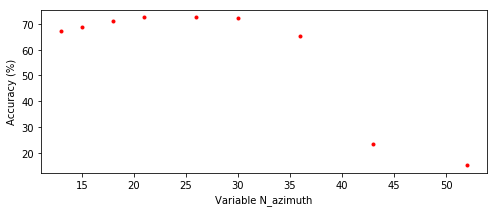

---> N_eccentricity


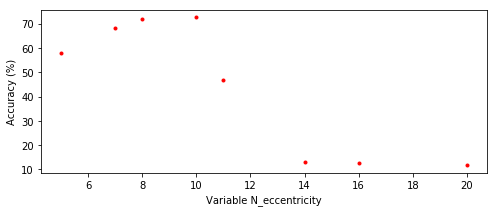

---> rho


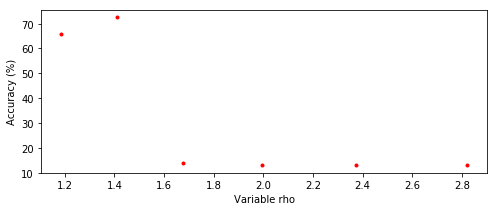

In [7]:
for parameter in results.keys():
    print('--->',  parameter)
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.plot(results[parameter]['value'], 
            results[parameter]['accuracy'], 'r.')
    plt.xlabel('Variable ' +  parameter)
    plt.ylabel('Accuracy (%)')

    plt.show()

In [8]:
results['sf_0']

{'value': [0.1,
  0.11892071150027211,
  0.14142135623730953,
  0.16817928305074292,
  0.2,
  0.23784142300054423,
  0.28284271247461906,
  0.33635856610148585,
  0.4],
 'accuracy': [66.62750000000001,
  67.2825,
  68.67750000000001,
  71.18749999999999,
  72.61999999999999,
  74.1175,
  75.1625,
  76.08250000000001,
  76.5725]}

In [18]:
def plot_accuracy(value, accuracy, xmin=10, fig=None, ax=None):
    if fig is None: fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(accuracy, value, "o", color='blue')
    # print(value, accuracy)
    ax.hlines(y=value, xmin=accuracy, xmax=100, color='red')
    ax.hlines(y=value, xmin=xmin, xmax=accuracy, color='skyblue')

    plt.ylabel(parameter.capitalize())
    #print( results[parameter]['value'] )
    #print( np.min([np.float(k) for k in results[parameter]['value']]))
    #ax.vlines(100, np.min(results[parameter]['value']), np.max(results[parameter]['value']), 'k', label='max')
    plt.xlabel('Accuracy (%)')
    # Only draw spine between the y-ticks
    #ax.spines['left'].set_bounds(-1, 1)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    return fig, ax

---> sf_0
[0.1, 0.11892071150027211, 0.14142135623730953, 0.16817928305074292, 0.2, 0.23784142300054423, 0.28284271247461906, 0.33635856610148585, 0.4] [66.62750000000001, 67.2825, 68.67750000000001, 71.18749999999999, 72.61999999999999, 74.1175, 75.1625, 76.08250000000001, 76.5725]


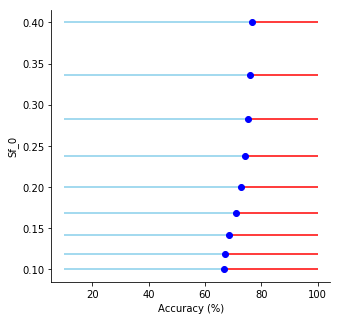

---> B_sf
[0.15, 0.17838106725040814, 0.21213203435596426, 0.25226892457611433, 0.3, 0.3567621345008163, 0.4242640687119285, 0.5045378491522287, 0.6] [72.96499999999999, 73.82000000000001, 73.30250000000001, 73.5675, 72.63499999999999, 71.46999999999998, 71.36, 70.11749999999999, 70.56750000000001]


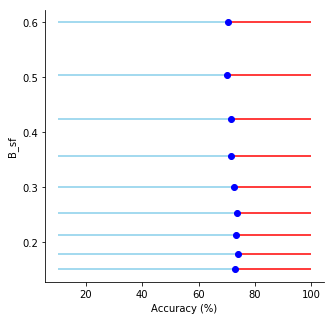

---> offset_std
[15, 17, 21, 25, 30, 35, 42, 50, 60] [79.765, 78.38499999999999, 77.21000000000001, 73.77, 72.61999999999999, 71.37, 67.86, 65.16999999999999, 63.347500000000004]


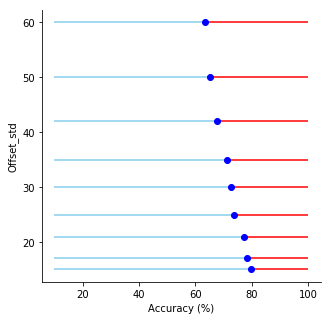

---> noise
[0.5, 0.5946035575013605, 0.7071067811865476, 0.8408964152537145, 1.0, 1.189207115002721, 1.4142135623730951, 1.681792830507429, 2.0] [81.82750000000001, 80.67, 79.1975, 76.01249999999999, 72.61999999999999, 67.6075, 59.2325, 49.614999999999995, 37.71]


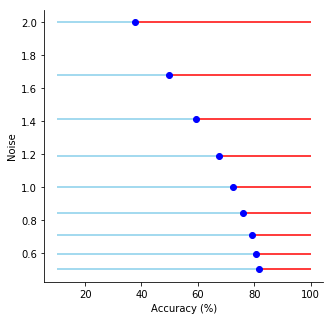

---> dim1
[250, 297, 353, 420, 500, 594, 707, 840, 1000] [73.32, 72.96, 73.49999999999999, 74.19999999999999, 72.61999999999999, 72.96000000000002, 72.60000000000001, 73.32000000000001, 72.12]


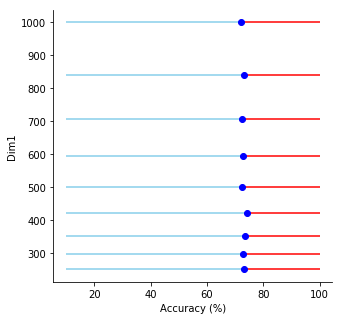

---> bn1_bn_momentum
[0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0] [72.66, 72.61999999999999, 72.74, 72.61999999999999, 72.61999999999999, 72.85999999999999, 73.05999999999999, 73.25999999999999, 16.78]


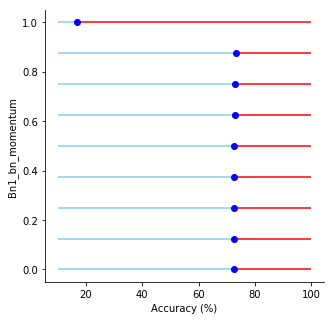

---> dim2
[1000, 1189, 1414, 1681, 2000, 2378, 2828, 3363, 4000] [72.47999999999999, 71.91999999999999, 72.38000000000001, 73.25999999999999, 72.61999999999999, 73.74000000000001, 74.02, 74.52, 73.62]


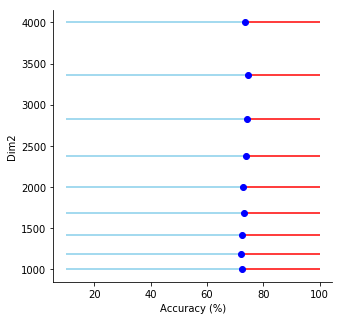

---> bn2_bn_momentum
[0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0] [74.24, 72.67999999999999, 72.69999999999999, 72.62, 72.6, 72.7, 72.82000000000001, 72.88000000000001, 69.18]


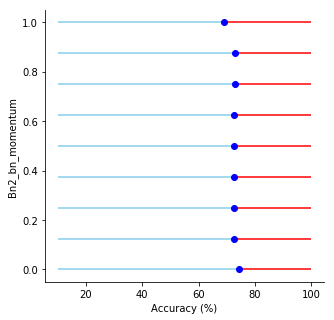

---> p_dropout
[0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0] [72.61999999999999, 72.82249999999999, 71.83, 70.415, 68.415, 63.89750000000001, 53.21, 33.282500000000006, 20.54]


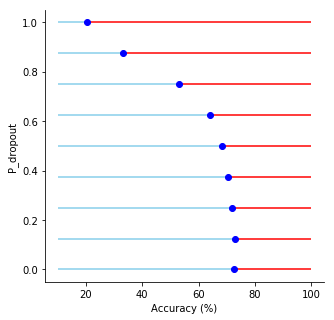

---> lr
[0.0005, 0.0005946035575013605, 0.0007071067811865476, 0.0008408964152537145, 0.001, 0.001189207115002721, 0.0014142135623730952, 0.001681792830507429, 0.002] [55.60000000000001, 55.60000000000001, 55.60000000000001, 55.60000000000001, 55.60000000000001, 55.60000000000001, 55.60000000000001, 74.04, 74.04]


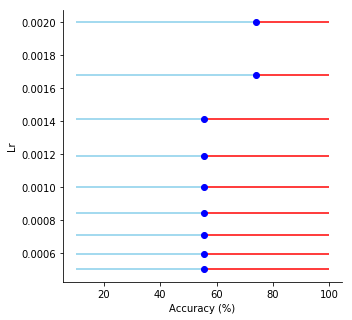

---> momentum
[0.05, 0.05946035575013606, 0.07071067811865477, 0.08408964152537146, 0.1, 0.11892071150027211, 0.14142135623730953, 0.16817928305074292, 0.2] [72.9, 73.14, 73.52, 73.24, 72.61999999999999, 73.00000000000001, 74.28, 72.92, 73.06]


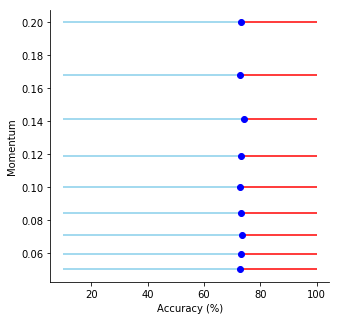

---> minibatch_size
[50, 59, 70, 84, 100, 118, 141, 168, 200] [72.61999999999999, 72.61999999999999, 72.61999999999999, 72.61999999999999, 72.61999999999999, 72.61999999999999, 72.61999999999999, 72.61999999999999, 72.61999999999999]


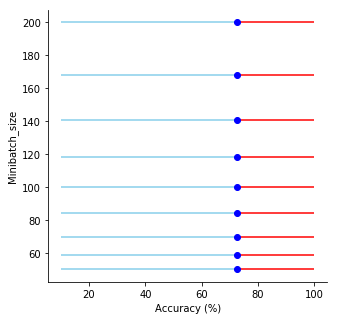

---> epochs
[12, 14, 17, 21, 25, 29, 35, 42, 50] [53.42, 64.6, 70.25999999999999, 72.22, 72.61999999999999, 73.10000000000001, 73.94, 73.97999999999999, 74.26]


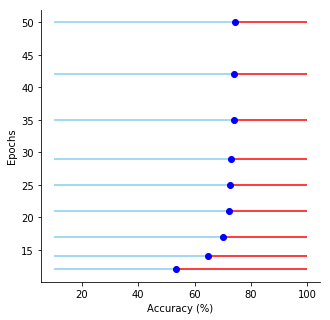

---> N_theta
[4, 6, 7, 8, 10, 12] [72.6825, 72.61999999999999, 72.96000000000001, 72.96999999999998, 72.725, 72.255]


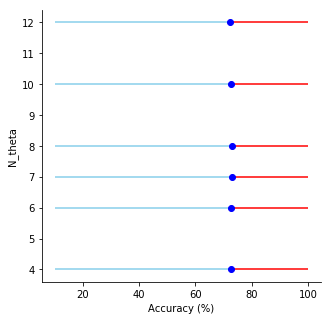

---> N_azimuth
[13, 15, 18, 21, 26, 30, 36, 43, 52] [67.3425, 68.945, 71.015, 72.6125, 72.61999999999999, 72.3, 65.47749999999999, 23.544999999999998, 15.0275]


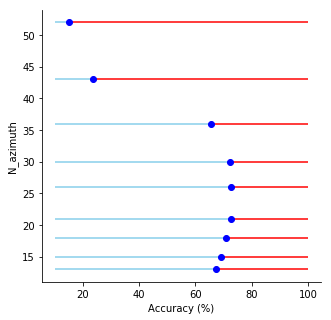

---> N_eccentricity
[5, 7, 8, 10, 11, 14, 16, 20] [57.835, 68.03500000000001, 71.92750000000001, 72.61999999999999, 46.777499999999996, 13.16, 12.790000000000001, 11.632499999999999]


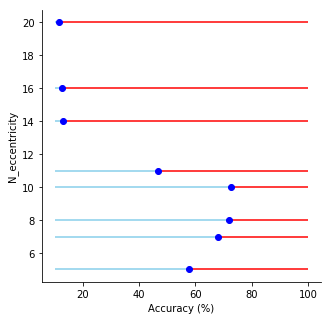

---> rho
[1.1856639455077373, 1.41, 1.6767820321538365, 1.994041122946064, 2.3713278910154747, 2.82] [65.7975, 72.61999999999999, 13.834999999999997, 12.969999999999999, 13.0025, 13.2625]


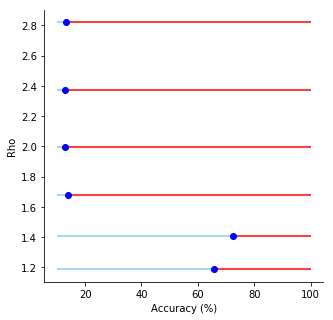

In [20]:
figname_ = 'accuracy_'
figname_ = ''

tex = ''
for parameter in results.keys():
    print('--->',  parameter)
    fig, ax = plot_accuracy(results[parameter]['value'], results[parameter]['accuracy'])
    plt.show()
    if not figname_ == '':
        fig_dir = './'
        fig_ext = '.pdf'
        fname = figname_ + parameter + fig_ext
        tex += "\includegraphics[width=.0666\linewidth]{"+ fname + "} \n"
        fig.savefig(os.path.join(fig_dir, fname),
                bbox_inches='tight', pad_inches=0)
print(tex)

# summary


[250, 297, 353, 420, 500, 594, 707, 840, 1000] [73.32, 72.96, 73.49999999999999, 74.19999999999999, 72.61999999999999, 72.96000000000002, 72.60000000000001, 73.32000000000001, 72.12]
[0.5, 0.5946035575013605, 0.7071067811865476, 0.8408964152537145, 1.0, 1.189207115002721, 1.4142135623730951, 1.681792830507429, 2.0] [81.82750000000001, 80.67, 79.1975, 76.01249999999999, 72.61999999999999, 67.6075, 59.2325, 49.614999999999995, 37.71]
[0.0005, 0.0005946035575013605, 0.0007071067811865476, 0.0008408964152537145, 0.001, 0.001189207115002721, 0.0014142135623730952, 0.001681792830507429, 0.002] [55.60000000000001, 55.60000000000001, 55.60000000000001, 55.60000000000001, 55.60000000000001, 55.60000000000001, 55.60000000000001, 74.04, 74.04]
[0.05, 0.05946035575013606, 0.07071067811865477, 0.08408964152537146, 0.1, 0.11892071150027211, 0.14142135623730953, 0.16817928305074292, 0.2] [72.9, 73.14, 73.52, 73.24, 72.61999999999999, 73.00000000000001, 74.28, 72.92, 73.06]
[12, 14, 17, 21, 25, 29, 35

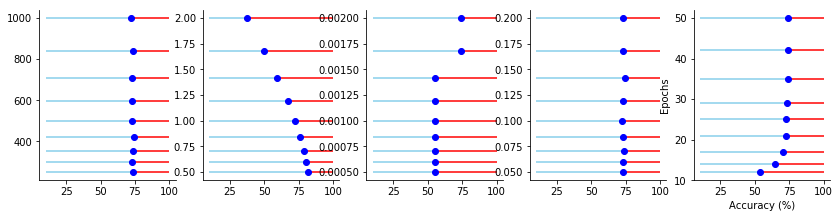

In [22]:
parameters = ['dim1', 'dim2', 'momentum', 'epochs'] # 'noise', 'lr', 
fig, axs = plt.subplots(1, len(parameters), figsize = (figwidth, figwidth/len(parameters)*1.1))

for ax, parameter in zip(axs, parameters):
    fig, ax = plot_accuracy(results[parameter]['value'], results[parameter]['accuracy'], xmin=10, fig=fig, ax=ax)

fig.savefig(figname + '.pdf', bbox_inches='tight', pad_inches=0.15)

In [12]:
figname + '.pdf'

'../paper/fig_params.pdf'

# post-processing

In [13]:
!convert  -density {dpi_export} {figname}.pdf {figname}.jpg
!convert  -density {dpi_export} {figname}.pdf {figname}.png
#!convert  -density {dpi_export} -resize 5400  -units pixelsperinch -flatten  -compress lzw  -depth 8 {fname}.pdf {fname}.tiff

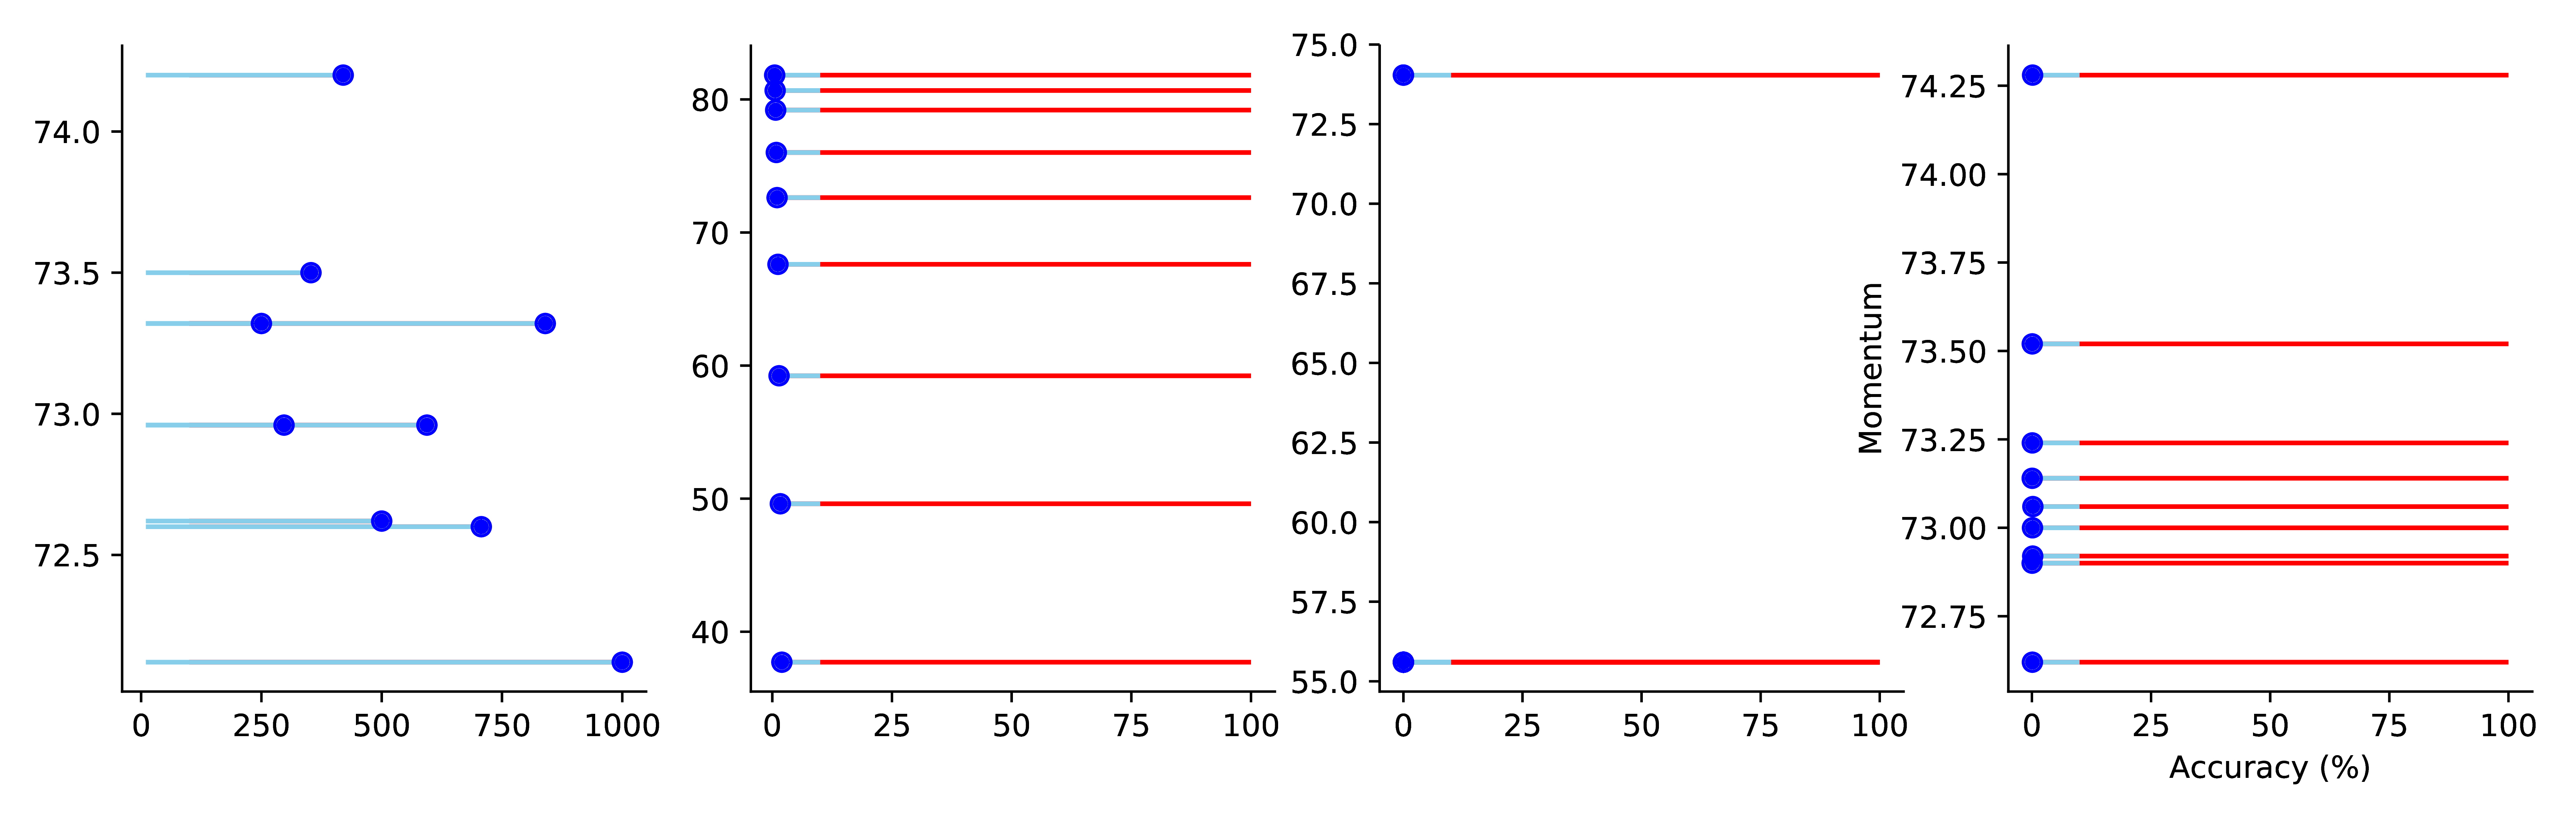

In [14]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))

In [15]:
!ls  -l {figname}*

-rw-r--r--  1 laurentperrinet  staff  733927 Mar 28 10:54 ../paper/fig_params.jpg
-rw-r--r--  1 laurentperrinet  staff   14859 Mar 28 10:54 ../paper/fig_params.pdf
-rw-r--r--  1 laurentperrinet  staff  103307 Mar 28 10:55 ../paper/fig_params.png
